In [1]:
!pip install -q pandas_ta==0.3.14b0
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd


# Load the dataset
data = pd.read_csv('/content/AUDUSD_data.csv')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Preview cleaned data
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-10,0.715758,0.718350,0.714090,0.715712,0.715712,0
1,2020-08-11,0.715530,0.719100,0.714630,0.715800,0.715800,0
2,2020-08-12,0.714900,0.717250,0.711040,0.714520,0.714520,0
3,2020-08-13,0.717103,0.718809,0.715690,0.716486,0.716486,0
4,2020-08-14,0.714790,0.717310,0.713300,0.714880,0.714880,0
...,...,...,...,...,...,...,...
1297,2025-08-04,0.647011,0.649000,0.646320,0.646910,0.646910,0
1298,2025-08-05,0.647501,0.647929,0.645090,0.647480,0.647480,0
1299,2025-08-06,0.647241,0.650809,0.647200,0.647299,0.647299,0
1300,2025-08-07,0.649971,0.653949,0.649241,0.650022,0.650022,0


In [3]:
import pandas as pd
import numpy as np

# Load your data
# Example: data = pd.read_csv('/content/EURUSD.csv')

# Shifted closing prices for previous days
data['T-4'] = data['Close']
data['T-3'] = data['Close'].shift(-1)
data['T-2'] = data['Close'].shift(-2)
data['T-1'] = data['Close'].shift(-3)
data['T0']  = data['Close'].shift(-4)

# Simple Moving Averages (5-day)
data['SMA_5_H'] = data['High'].rolling(window=5).mean().shift(-4)
data['SMA_5_L'] = data['Low'].rolling(window=5).mean().shift(-4)

# Exponential Moving Average (5-day)
data['EMA_5_C'] = data['Close'].ewm(span=5, adjust=False).mean().shift(-4)

# RSI (Relative Strength Index, 14-day)
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi.shift(-14)

# Future target closing price
data['T_F'] = data['Close'].shift(-5)

# Show first few rows
print(data.head(10))


        Date      Open      High      Low     Close  Adj Close  Volume  \
0 2020-08-10  0.715758  0.718350  0.71409  0.715712   0.715712       0   
1 2020-08-11  0.715530  0.719100  0.71463  0.715800   0.715800       0   
2 2020-08-12  0.714900  0.717250  0.71104  0.714520   0.714520       0   
3 2020-08-13  0.717103  0.718809  0.71569  0.716486   0.716486       0   
4 2020-08-14  0.714790  0.717310  0.71330  0.714880   0.714880       0   
5 2020-08-17  0.719400  0.722700  0.71721  0.719259   0.719259       0   
6 2020-08-18  0.721522  0.726470  0.72099  0.721813   0.721813       0   
7 2020-08-19  0.725360  0.727600  0.72286  0.725795   0.725795       0   
8 2020-08-20  0.718458  0.719400  0.71375  0.718804   0.718804       0   
9 2020-08-21  0.720622  0.721605  0.71407  0.720612   0.720612       0   

        T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
0  0.715712  0.715800  0.714520  0.716486  0.714880  0.718164  0.713750   
1  0.715800  0.714520  0.716486  0.

In [4]:
print(data.tail(10))

           Date      Open      High       Low     Close  Adj Close  Volume  \
1292 2025-07-28  0.657289  0.658700  0.651630  0.657298   0.657298       0   
1293 2025-07-29  0.652061  0.653000  0.649640  0.652401   0.652401       0   
1294 2025-07-30  0.651521  0.652910  0.644920  0.651322   0.651322       0   
1295 2025-07-31  0.644571  0.647731  0.642860  0.644712   0.644712       0   
1296 2025-08-01  0.642820  0.649300  0.641950  0.642909   0.642909       0   
1297 2025-08-04  0.647011  0.649000  0.646320  0.646910   0.646910       0   
1298 2025-08-05  0.647501  0.647929  0.645090  0.647480   0.647480       0   
1299 2025-08-06  0.647241  0.650809  0.647200  0.647299   0.647299       0   
1300 2025-08-07  0.649971  0.653949  0.649241  0.650022   0.650022       0   
1301 2025-08-08  0.652273  0.653680  0.651360  0.652967   0.652967       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1292  0.657298  0.652401  0.651322  0.644712  0.642909  0.65232

In [5]:
# Dropping NaN values
data.dropna(inplace=True)

print(data.tail(10))


           Date      Open      High       Low     Close  Adj Close  Volume  \
1278 2025-07-08  0.650770  0.655029  0.650720  0.650610   0.650610       0   
1279 2025-07-09  0.652388  0.654742  0.651139  0.652452   0.652452       0   
1280 2025-07-10  0.653612  0.657289  0.653488  0.653590   0.653590       0   
1281 2025-07-11  0.659370  0.659378  0.655781  0.659400   0.659400       0   
1282 2025-07-14  0.657838  0.658900  0.654890  0.657808   0.657808       0   
1283 2025-07-15  0.654412  0.657480  0.650940  0.654472   0.654472       0   
1284 2025-07-16  0.652150  0.655140  0.649591  0.651899   0.651899       0   
1285 2025-07-17  0.652341  0.652341  0.645590  0.652500   0.652500       0   
1286 2025-07-18  0.649849  0.654069  0.649709  0.649819   0.649819       0   
1287 2025-07-21  0.651249  0.653830  0.649860  0.651211   0.651211       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1278  0.650610  0.652452  0.653590  0.659400  0.657808  0.65706

In [6]:
data = data[['Date', 'T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI','T_F']]

data

,Date,T-4,T-3,T-2,T-1,T0,SMA_5_H,SMA_5_L,EMA_5_C,RSI,T_F
0,2020-08-10,0.715712,0.715800,0.714520,0.716486,0.714880,0.718164,0.713750,0.715439,64.104078,0.719259
1,2020-08-11,0.715800,0.714520,0.716486,0.714880,0.719259,0.719034,0.714374,0.716712,71.413001,0.721813
2,2020-08-12,0.714520,0.716486,0.714880,0.719259,0.721813,0.720508,0.715646,0.718413,73.711560,0.725795
3,2020-08-13,0.716486,0.714880,0.719259,0.721813,0.725795,0.722578,0.718010,0.720873,72.250040,0.718804
4,2020-08-14,0.714880,0.719259,0.721813,0.725795,0.718804,0.722696,0.717622,0.720183,67.824866,0.720612
...,...,...,...,...,...,...,...,...,...,...,...
1283,2025-07-15,0.654472,0.651899,0.652500,0.649819,0.651211,0.654572,0.649138,0.652050,40.031494,0.652810
1284,2025-07-16,0.651899,0.652500,0.649819,0.651211,0.652810,0.654190,0.649046,0.652303,43.849156,0.655471
1285,2025-07-17,0.652500,0.649819,0.651211,0.652810,0.655471,0.655174,0.650148,0.653359,42.676022,0.660400
1286,2025-07-18,0.649819,0.651211,0.652810,0.655471,0.660400,0.657209,0.652975,0.655706,50.285237,0.659718


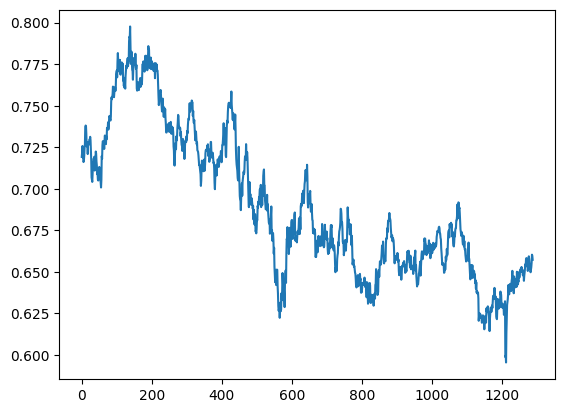

In [7]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['T_F'])

In [8]:
dates=data['Date'].to_numpy()
middle_matrix =data[['T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI']].to_numpy()
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
Y=data['T_F']

print(dates.shape)
print(X.shape)
print(Y.shape)

(1288,)
(1288, 9, 1)
(1288,)


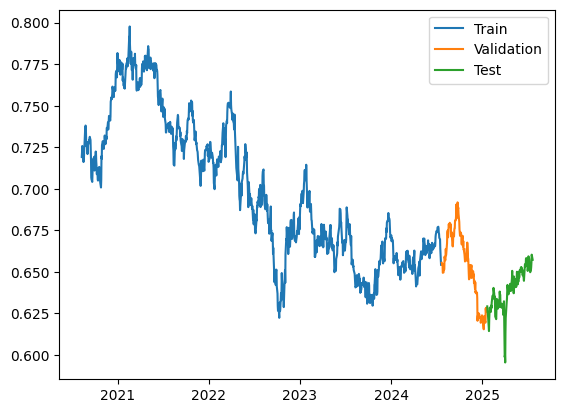

In [9]:
q_80 = int(len(dates) * .8) #change to 0.8
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import numpy as np
import time

def evaluate_network(lstm_units_1,epochs,learning_rate,dense_units_1,dense_units_2):

  lstm_units_1=int(lstm_units_1)
  epochs=int(epochs)
  dense_units_1=int(dense_units_1)
  dense_units_2=int(dense_units_2)

  model = Sequential([layers.Input((9, 1)),
                      layers.LSTM(lstm_units_1),
                      layers.Dense(dense_units_1, activation='relu'),
                      layers.Dense(dense_units_2, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])


  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)

  # Return the loss (or another metric that you want to minimize)
  val_loss=min(history.history['val_loss'])
  loss=min(history.history['loss'])

  return -(val_loss*loss)  # Negative because BayesianOptimization maximizes, but we want to minimize loss



pbounds = {
    'lstm_units_1': (20, 300),
    'learning_rate': (1e-6, 1e-2),
    'epochs': (10, 150),
    'dense_units_1': (10, 200),
    'dense_units_2': (10, 200)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    )

# Run the optimization
start_time = time.time()
optimizer.maximize(init_points=20, n_iter=40)
time_took = (time.time() - start_time)/60


# Get the best hyperparameters
print(f"Total runtime in mins: {time_took}")
best_params = optimizer.max['params']
print(f"Best hyperparameters: {best_params}")


|   iter    |  target   | lstm_u... | learni... |  epochs   | dense_... | dense_... |
-------------------------------------------------------------------------------------
| 1         | -3.14e-09 | 136.76616 | 0.0072035 | 10.016012 | 67.443188 | 37.883619 |
| 2         | -7.52e-10 | 45.854806 | 0.0018634 | 58.378501 | 85.385820 | 112.37517 |
| 3         | -1.14e-09 | 137.37446 | 0.0068525 | 38.623314 | 176.84231 | 15.203642 |
| 4         | -9.65e-10 | 207.73090 | 0.0041736 | 88.216575 | 36.673518 | 47.639282 |
| 5         | -1.22e-09 | 244.20847 | 0.0096826 | 53.879384 | 141.54129 | 176.51393 |
| 6         | -1.73e-09 | 270.48986 | 0.0008513 | 15.467669 | 42.267779 | 176.84707 |
| 7         | -6.30e-10 | 47.537113 | 0.0042116 | 144.10453 | 111.30140 | 141.45665 |
| 8         | -9.77e-10 | 108.34437 | 0.0068653 | 126.84759 | 13.474772 | 152.52741 |
| 9         | -1.32e-09 | 296.88110 | 0.0074819 | 49.262158 | 159.96307 | 29.612941 |
| 10        | -1.57e-09 | 145.41018 | 0.0090860 | 51.1

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0696 - mean_absolute_error: 0.1867 - val_loss: 0.0013 - val_mean_absolute_error: 0.0296
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0353 - val_loss: 0.0017 - val_mean_absolute_error: 0.0369
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mean_absolute_error: 0.0340 - val_loss: 6.4646e-04 - val_mean_absolute_error: 0.0201
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0320 - val_loss: 7.1857e-04 - val_mean_absolute_error: 0.0219
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_error: 0.0320 - val_loss: 0.0011 - val_mean_absolute_error: 0.0292
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3056e-04 - mean_absolute_error: 0.0245 - val_loss: 8.1991e-04 - val_mean_absolute_error: 0.0270
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5869e-04 - mean_absolute_error: 0.

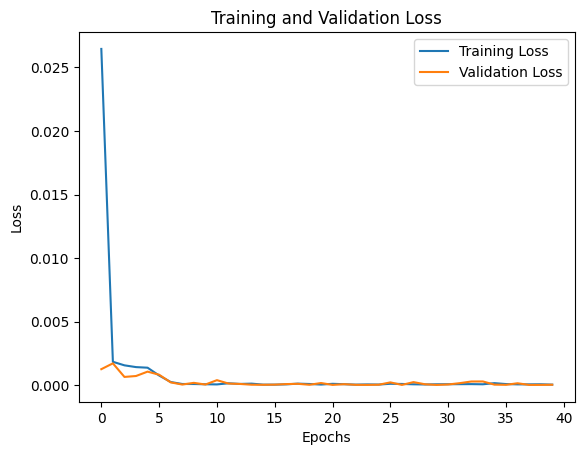

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model = Sequential([layers.Input((9, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(1)])

model = Sequential([layers.Input((9, 1)),
                   layers.LSTM(25),
                   layers.Dense(60, activation='relu'),
                   layers.Dense(103, activation='relu'),
                   layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00678867649386597),
              metrics=['mean_absolute_error'])


history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40)

print(history.history.keys())

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


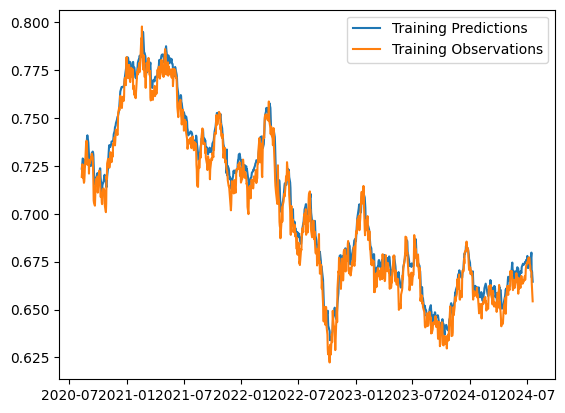

In [12]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

56.63297435785824


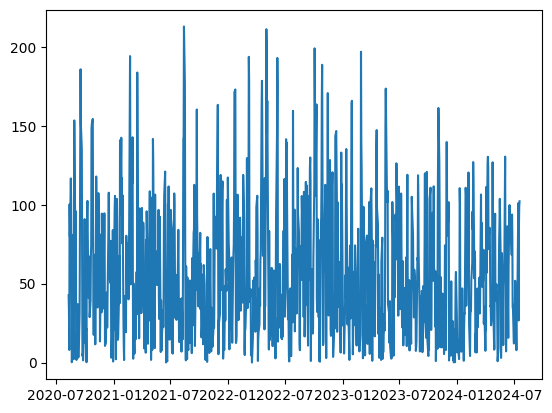

In [13]:
import numpy as np

basis_point_value=0.0001  #For EURUSD pair
train_data_basis_point_diff=((train_predictions/basis_point_value).flatten()-y_train/basis_point_value).abs()
plt.plot(dates_train, train_data_basis_point_diff)

average_train_data_basis_point_diff=np.mean(train_data_basis_point_diff)
print(average_train_data_basis_point_diff)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


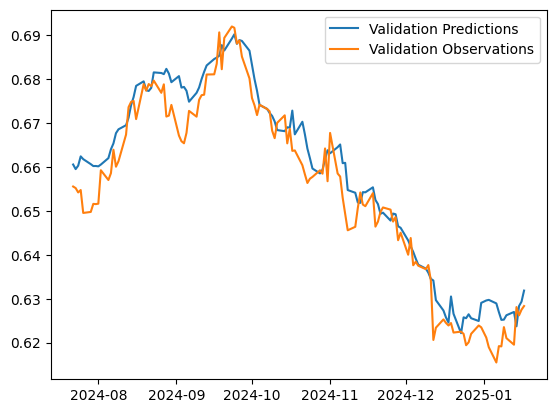

In [14]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

44.696501331153286


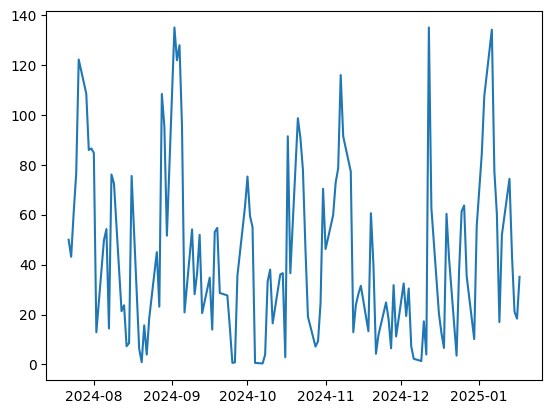

In [15]:
basis_point_value=0.0001  #For EURUSD pair
validation_data_basis_point_diff=((val_predictions/basis_point_value).flatten()-y_val/basis_point_value).abs()
plt.plot(dates_val, validation_data_basis_point_diff)

print(np.mean(validation_data_basis_point_diff))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


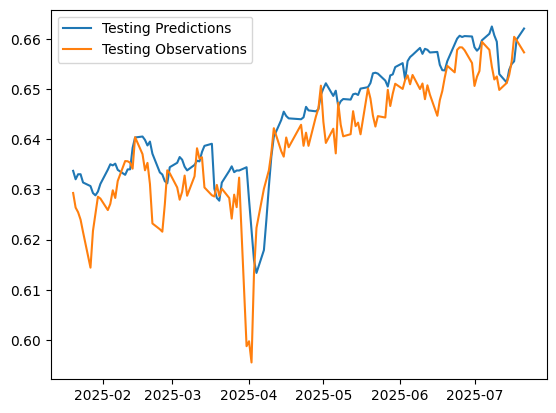

In [16]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Assuming test_predictions and y_test are lists or numpy arrays
# Calculate MSE and MAE
mse = mean_squared_error(y_test, test_predictions)
print("Mean Square Error:", mse)
mae=mean_absolute_error(y_test, test_predictions)
print("Mean Absolute Error:", mae)

Mean Square Error: 5.8547868577611955e-05
Mean Absolute Error: 0.0056790871349404505


56.79096225896337


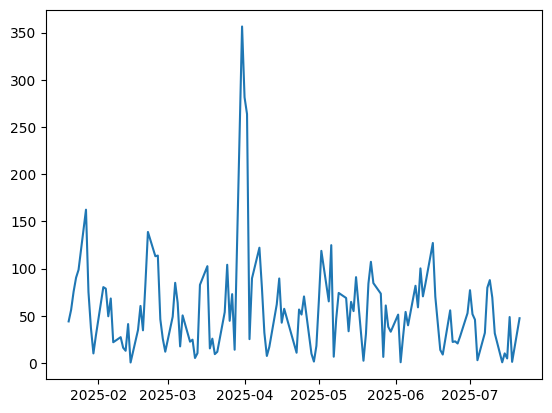

In [18]:
basis_point_value=0.0001  #For AUDUSD pair
test_data_basis_point_diff=((test_predictions/basis_point_value).flatten()-y_test/basis_point_value).abs()
plt.plot(dates_test, test_data_basis_point_diff)

print(np.mean(test_data_basis_point_diff))

In [19]:
#Start Trading with 1000 USD with model


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_predictions[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_predictions[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)


129
1045.7664063938844
base


In [20]:
#Start Trading with 1000 USD with actual values


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_data[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_data[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)

129
1432.1063371555656
quote


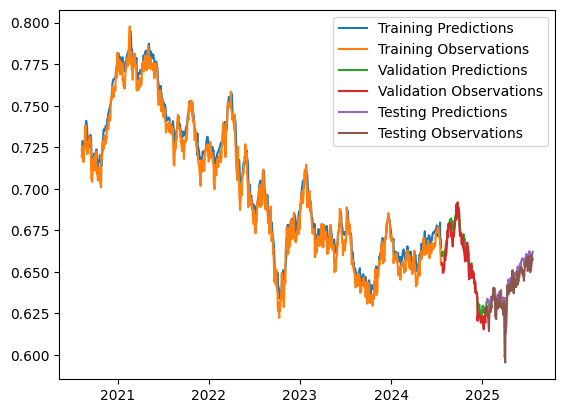

In [21]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])